# Prologue

- We we’ll use the “Economic News Article Tone and Relevance” dataset. 
- It consists of 8,000 news articles annotated with whether or not they’re **relevant to the US economy** (i.e., a yes/no binary classification). 
- The dataset is also imbalanced, with ~1,500 relevant and ~6,500 non-relevant articles, which poses the challenge of guarding against learning a bias toward the majority category (in this case, non-relevant articles).

# Importing Modules

In [59]:
import re
import string
import warnings
import itertools

import numpy                         as np
import pandas                        as pd
import matplotlib                    as mpl
import matplotlib.pyplot             as plt
import matplotlib.cm                 as cm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction      import _stop_words
from sklearn.model_selection         import train_test_split

from sklearn.naive_bayes             import MultinomialNB
from sklearn.linear_model            import LogisticRegression
from sklearn.svm                     import LinearSVC

from sklearn                         import metrics
from sklearn.metrics                 import accuracy_score, confusion_matrix, roc_auc_score

import time

In [2]:
warnings.filterwarnings("ignore")

# Dataset

In [3]:
df = pd.read_csv("data/Full-Economic-News-DFE-839861.csv", encoding = "ISO-8859-1")

In [4]:
df.shape

(8000, 15)

In [5]:
df.head(3)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.64,yes,0.64,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.00,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.00,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...


## Class Distribution

In [6]:
df['relevance'].value_counts()

no          6571
yes         1420
not sure       9
Name: relevance, dtype: int64

In [10]:
df["relevance"].value_counts() / df.shape[0] # Class distribution in the dataset

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

- There is an **imbalance** in the data with **not relevant** being 82% in the dataset.
- That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics.
- We should keep this class imbalance mind when interpreting the classifier performance later. 
- Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure".

# Data Cleaning

## Renaming Columns

In [10]:
print(list(df.columns))

['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'positivity', 'positivity:confidence', 'relevance', 'relevance:confidence', 'articleid', 'date', 'headline', 'positivity_gold', 'relevance_gold', 'text']


In [11]:
new_columns = ["Unit ID", "Golden", "Unit State", "Trusted Judgements", "Last Judgement at", "Positivity", "Positivity Confidence", "Relevance", "Relevance Confidence",
 "Article ID", "Date", "Headline", "Positivity Gold", "Relevance Gold", "Text"]

In [13]:
df.rename(columns = dict(zip(list(df.columns), new_columns)), inplace = True)

In [14]:
df.head(3)

,Unit ID,Golden,Unit State,Trusted Judgements,Last Judgement at,Positivity,Positivity Confidence,Relevance,Relevance Confidence,Article ID,Date,Headline,Positivity Gold,Relevance Gold,Text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.64,yes,0.64,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.00,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.00,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...


## Rearranging Columns

In [15]:
df = df[["Article ID", "Date", "Headline", "Text", "Unit ID", "Unit State", "Golden", "Trusted Judgements", "Last Judgement at", 
         "Positivity", "Positivity Confidence", "Positivity Gold", "Relevance Gold", "Relevance", "Relevance Confidence",]]

In [16]:
df.head()

,Article ID,Date,Headline,Text,Unit ID,Unit State,Golden,Trusted Judgements,Last Judgement at,Positivity,Positivity Confidence,Positivity Gold,Relevance Gold,Relevance,Relevance Confidence
0,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...,842613455,finalized,False,3,12/5/15 17:48,3.0,0.6400,NaN,NaN,yes,0.640
1,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...,842613456,finalized,False,3,12/5/15 16:54,NaN,NaN,NaN,NaN,no,1.000
2,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...,842613457,finalized,False,3,12/5/15 1:59,NaN,NaN,NaN,NaN,no,1.000
3,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...,842613458,finalized,False,3,12/5/15 2:19,NaN,0.0000,NaN,NaN,no,0.675
4,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...,842613459,finalized,False,3,12/5/15 17:48,3.0,0.3257,NaN,NaN,yes,0.640


## Normalizing Labels

### Removing Unwanted (Not Sure) Data

In [21]:
df.Relevance.value_counts()

no     6571
yes    1420
Name: Relevance, dtype: int64

In [19]:
df = df[df.Relevance != "not sure"]

In [20]:
df.shape

(7991, 15)

### Mapping to 0/1

In [22]:
df['Relevance'] = df.Relevance.map({"yes": 1, "no": 0})

## Reducing Dataset to Columns of Interests

In [24]:
df = df[['Text', "Relevance"]]

In [25]:
df.shape

(7991, 2)

In [26]:
df.head()

,Text,Relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


## Text Pre-Processing

In [27]:
stopwords = _stop_words.ENGLISH_STOP_WORDS

In [49]:
# To be called upon vectorizing
def clean(document):
    document = document.replace("</br>", " ")
    document = "".join([char for char in document if char not in string.punctuation and not char.isdigit()]) #Removing Punctutation and Numeric Digits
    document = " ".join([token for token in document.split() if token not in stopwords]) #Removing Stopwords
    return document

# Splitting The Data

In [31]:
X = df.Text
y = df.Relevance

In [32]:
X.shape

(7991,)

In [33]:
y.shape

(7991,)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [36]:
X_train.shape

(5993,)

In [37]:
X_test.shape

(1998,)

# Vectorizing

In [50]:
vectorizer = CountVectorizer(preprocessor = clean) #Calling Cleaning Function

In [51]:
# use it to extract features from training data
X_train_ = vectorizer.fit_transform(X_train)

In [53]:
# transform testing data (using training data's features)
X_test_ = vectorizer.transform(X_test)

In [54]:
X_train_.shape

(5993, 49753)

In [55]:
X_test_.shape

(1998, 49753)

# Training The Models

## Naive-Bayes Classifier

In [56]:
NB_Classifier = MultinomialNB()

In [57]:
%time 
NB_Classifier.fit(X_train_, y_train)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


MultinomialNB()

In [58]:
y_pred_class = NB_Classifier.predict(X_test_)

# Evaluation

## Accuracy

In [62]:
accuracy_score(y_test, y_pred_class)

0.7822822822822822

## Confusion Matrix

In [63]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)

In [64]:
cnf_matrix

array([[1420,  236],
       [ 199,  143]])

## AUC

In [66]:
y_pred_prob = NB_Classifier.predict_proba(X_test_)[:, 1]

In [67]:
roc_auc_score(y_test, y_pred_prob)

0.7251117679464362

In [61]:
def plot_confusion_matrix(cm, classes, normalize = False, title = "Confusion Matrix", cmap = plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)

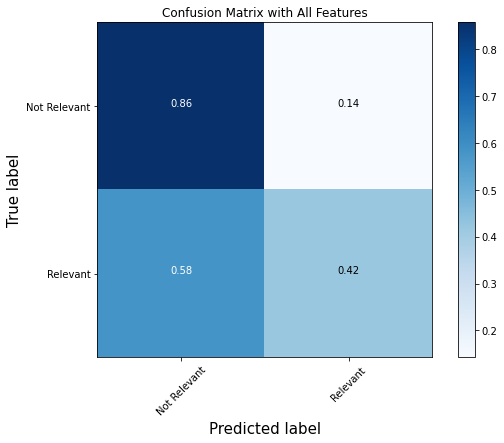

In [65]:
plt.figure(figsize = (8, 6))

plot_confusion_matrix(cnf_matrix, classes=['Not Relevant', 'Relevant'], normalize = True, title = 'Confusion Matrix with All Features')

- At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. 
- Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. 
- Let us change the count vectorizer to take a certain number of features as maximum.

# Reinstantiating Vectorizer

In [68]:
vectorizer = CountVectorizer(preprocessor = clean, max_features = 5000)

In [69]:
X_train_ = vectorizer.fit_transform(X_train)

In [70]:
X_test_ = vectorizer.transform(X_test)

In [71]:
NB_Classifier = MultinomialNB()

In [72]:
%time 
NB_Classifier.fit(X_train_, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


MultinomialNB()

In [73]:
y_pred_class = NB_Classifier.predict(X_test_)

In [74]:
accuracy_score(y_test, y_pred_class)

0.6876876876876877

In [75]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)

In [76]:
cnf_matrix

array([[1152,  504],
       [ 120,  222]])

In [77]:
y_pred_prob = NB_Classifier.predict_proba(X_test_)[:, 1]

In [78]:
roc_auc_score(y_test, y_pred_prob)

0.7282608695652173

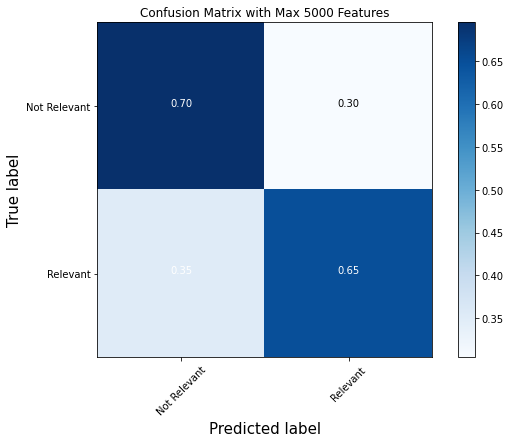

In [79]:
plt.figure(figsize = (8, 6))
plot_confusion_matrix(cnf_matrix, classes = ['Not Relevant', 'Relevant'], normalize = True, title = 'Confusion Matrix with Max 5000 Features')

- Clearly, the performance on relevance classification got better even though the overall accuracy fell by 10%.
- Let us try another classification algorithm and see if the performance changes.
- For this experiment, we have considered logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset.

## Logistic Regressor

In [80]:
LogReg = LogisticRegression(class_weight = "balanced")

In [81]:
LogReg.fit(X_train_, y_train)

LogisticRegression(class_weight='balanced')

In [82]:
y_pred_class = LogReg.predict(X_test_)

# Evaluation

## Accuracy

In [83]:
accuracy_score(y_test, y_pred_class)

0.7357357357357357

## Confusion Matrix

In [84]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)

In [85]:
cnf_matrix

array([[1352,  304],
       [ 224,  118]])

## AUC

In [86]:
y_pred_prob = LogReg.predict_proba(X_test_)[:, 1]

In [87]:
roc_auc_score(y_test, y_pred_prob)

0.6585091956945505

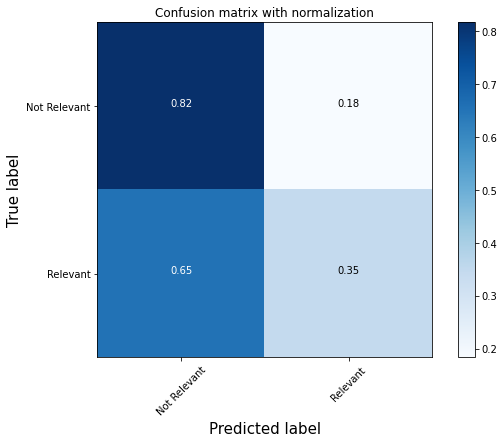

In [88]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix, classes = ['Not Relevant','Relevant'], normalize = True, title = 'Confusion matrix with normalization')

# Evaluation

## Accuracy

In [83]:
accuracy_score(y_test, y_pred_class)

0.7357357357357357

## Confusion Matrix

In [84]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)

In [85]:
cnf_matrix

array([[1352,  304],
       [ 224,  118]])

## AUC

In [86]:
y_pred_prob = LogReg.predict_proba(X_test_)[:, 1]

In [87]:
roc_auc_score(y_test, y_pred_prob)

0.6585091956945505

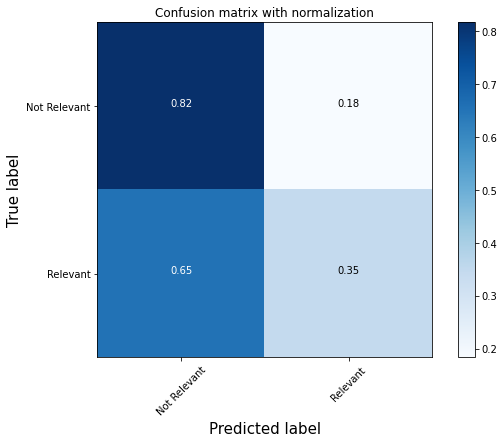

In [88]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix, classes = ['Not Relevant','Relevant'], normalize = True, title = 'Confusion matrix with normalization')

# Reinstantiating Vectorizer with SVM

In [89]:
vectorizer = CountVectorizer(preprocessor = clean, max_features = 1000)

In [90]:
X_train_ = vectorizer.fit_transform(X_train)

In [91]:
X_test_ = vectorizer.transform(X_test)

In [92]:
SVM_Classifier = LinearSVC(class_weight = "balanced")

In [94]:
%time 
SVM_Classifier.fit(X_train_, y_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


LinearSVC(class_weight='balanced')

In [95]:
y_pred_class = SVM_Classifier.predict(X_test_)

In [96]:
accuracy_score(y_test, y_pred_class)

0.6986986986986987

In [97]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)

In [98]:
cnf_matrix

array([[1222,  434],
       [ 168,  174]])

In [100]:
roc_auc_score(y_test, y_pred_prob)

0.6585091956945505

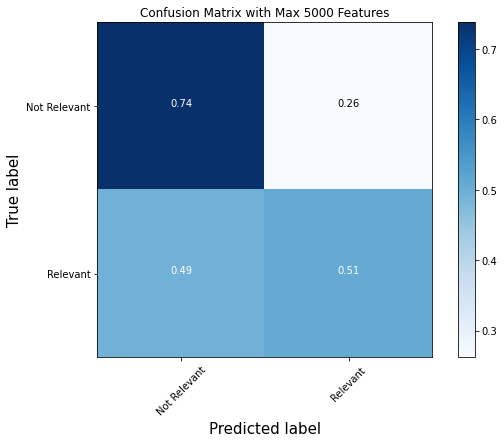

In [101]:
plt.figure(figsize = (8, 6))
plot_confusion_matrix(cnf_matrix, classes = ['Not Relevant', 'Relevant'], normalize = True, title = 'Confusion Matrix with Max 5000 Features')

- Clearly, the performance on relevance classification got better even though the overall accuracy fell by 10%.
- Let us try another classification algorithm and see if the performance changes.
- For this experiment, we have considered logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset.

# Epilogue

- So, how do we choose whats the best? 
- If we look at overall accuracy alone, we should be choosing the very first classifier in this notebook.
- However, that is also doing poorly with identifying "relevant" articles. 
- If we choose purely based on how good it is doing with "relevant" category, we should choose the second one we built. 
- If we choose purely based on how good it is doing with "irrelevant" category, surely, nothing beats not building any classifier and just calling everything irrelevant! 
- So, what to choose as the best among these depends on what we are looking for in our usecase!